This is a simple implementation of variational autoencoders (VAE)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        h1 = 256
        h2 = 64     # Latent vector size
        self.h = nn.Linear(28*28, h1)
        self.l_mu = nn.Linear(h1, h2)
        self.l_log_var = nn.Linear(h1, h2)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.h(x))
        
        mu = self.l_mu(x)
        log_var = self.l_log_var(x)
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        h1 = 64     # Latent vector size
        h2 = 256
        self.l1 = nn.Linear(h1, h2)
        self.l2 = nn.Linear(h2, 28*28)    
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.tanh(self.l2(x))
        return x

In [3]:
# load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

In [30]:
encoder = Encoder()
decoder = Decoder()

optimizer = torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()))
beta = 0.1      # KL divergence coefficient
max_epoches = 20

losses = []

In [31]:
# Train and log the losses
for epoch in range(max_epoches):
    for image, _ in trainloader:
        mu, log_var = encoder(image)
        noise = torch.randn(mu.shape)
        z = mu + (log_var / 2).exp() * noise
        dec = decoder(z)
        
        # Reconstruction and KL-divergence loss
        loss_recon = F.mse_loss(image.view(-1, 28*28), dec)
        loss_kl = -0.5 * (1 - log_var.exp() - mu**2 + log_var).mean()
        
        loss = loss_recon + beta * loss_kl
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach())

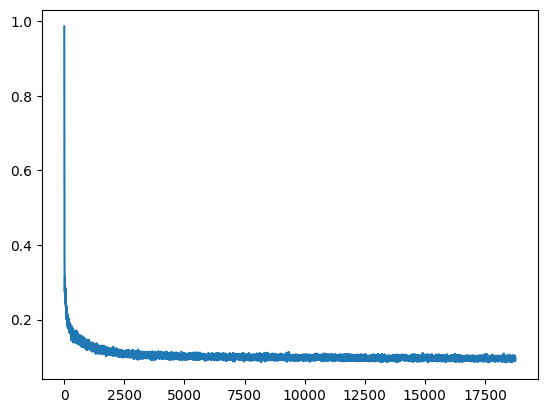

In [32]:
plt.plot(losses)
plt.show()

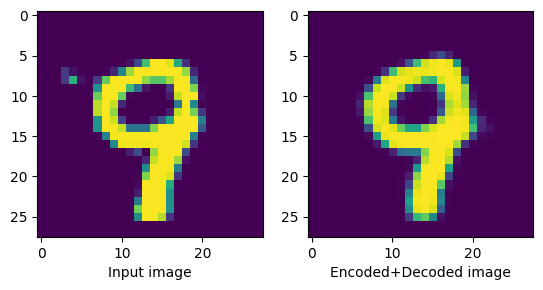

In [61]:
# Test the model by encoding and decoding a training image

n = random.choice(range(image.shape[0]))

plt.subplot(1, 2, 1)
plt.xlabel('Input image')
plt.imshow(image[n].squeeze())

plt.subplot(1, 2, 2)
plt.xlabel('Encoded+Decoded image')
plt.imshow(dec[n].view(28, 28).detach())
plt.show()

Now let's try to generate unseen data by adding some noise to the original encoded vector.

torch.Size([64])


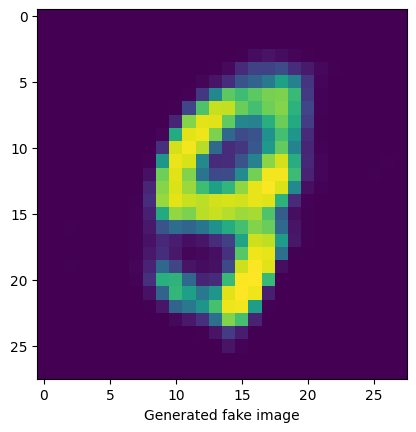

In [91]:
noise = torch.randn(mu.shape[1])
fake_image = decoder(noise).view(28, 28).detach()

plt.imshow(fake_image)
plt.xlabel('Generated fake image')
plt.show()